In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# area_num = -1

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from joblib import parallel_backend
from tqdm import tqdm
import time
from sklearn.utils import resample
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

def impute_data(data):
    imp = IterativeImputer(max_iter=10, random_state=0)
    X = data.drop('Date', axis=1)
    data_imputed = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

    data_imputed["Date"] = data["Date"]
    return data

def import_data(ma_window, area_num):
    macro = pd.read_csv("/content/drive/MyDrive/GRAD/macroeconomics.csv", index_col=0)
    areas_prices = pd.read_csv("/content/drive/MyDrive/GRAD/ppm_2017_2024_areas_final_v8.csv", index_col=0)

    areas = areas_prices.columns
    area = areas[area_num]
    areas_prices = areas_prices.reset_index()
    areas_prices = areas_prices[[area, "Date"]]
    areas_prices = areas_prices.melt(id_vars='Date', var_name='Area', value_name='Price Per Meter')

    alex = pd.merge(macro, areas_prices, on="Date", how="left")
    alex = alex.drop(["Area"], axis=1)
    alex = alex.dropna(subset=['Price Per Meter'])
    alex = alex.drop(["Alexandria's Real Estate Ownership (GDP) (Thousands EGP)"], axis=1)
    alex['Year'] = alex['Date'].str[:4]
    alex['Quarter'] = alex['Date'].str[5:].astype(int)
    alex = alex.drop_duplicates(subset=["Date"]).reset_index(drop=True)

    og_columns = list(alex.columns)

    if ma_window > 0:
        for col in alex.columns:
            if col in ["Date", "Year", "Quarter", "Price Per Meter"]:
                continue

            ma = col + "_ma"
            alex[ma] = alex[col].rolling(window=ma_window).mean()

        alex = impute_data(alex)
        alex.attrs['area'] = area

    alex.attrs['area'] = area

    return (alex)

def select_lags(alex, lags_n):
    lags = {}
    for col in alex.columns:
        if col in ["Date", "Year", "Quarter", "Price Per Meter"]:
            continue

        for i in range(1,lags_n):
            lag = col + "_lag_" + str(i)
            lags[lag] = alex[col].shift(i)

    lags_df = pd.concat(lags, axis=1)

    X = lags_df
    X.fillna(0, inplace=True)
    y = alex['Price Per Meter']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    tscv = TimeSeriesSplit(n_splits=5)

    lasso = LassoCV(cv=tscv)
    lasso.fit(X_scaled, y)

    coef = pd.Series(lasso.coef_, index=X.columns)
    selected_lags = coef[coef != 0].index.tolist()

    lags_df = lags_df.drop(columns=[col for col in lags_df.columns if col not in selected_lags], axis=1)

    area = alex.attrs['area']
    alex = pd.concat([alex, lags_df], axis=1)
    alex.set_index("Date", inplace=True)
    alex.attrs['area'] = area

    return alex

def data_preprocessing(alex, pca_comp, tst_size):
    # alex["Price Per Meter"] = np.log1p(alex["Price Per Meter"])
    # alex["Price Per Meter"] = alex["Price Per Meter"] - alex["Price Per Meter"].shift(1)
    # alex = alex.dropna(subset=['Price Per Meter'])
    X = alex.drop(["Price Per Meter"], axis=1)
    y = alex["Price Per Meter"]
    print(alex.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tst_size, shuffle=False)
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 1))

    X_train = create_pca_comp(X_train, pca_comp)
    X_test = create_pca_comp(X_test, pca_comp)

    X_train["Quarter"] = X_train["Quarter"].astype(int)
    X_test["Quarter"] = X_test["Quarter"].astype(int)
    X_test["Year"] = X_test["Year"].astype(int)
    X_train["Year"] = X_train["Year"].astype(int)

    return (X_train, X_test, y_train, y_test)

def create_pca_comp(X, pca_comp):
    date = X[['Year', 'Quarter']]
    pca = PCA(n_components=pca_comp)
    X.fillna(0, inplace=True)
    X_pca = pca.fit_transform(X.drop(["Year", "Quarter"], axis=1))

    df_pca = pd.DataFrame(X_pca, columns=[f'pca_{i+1}' for i in range(X_pca.shape[1])])
    X = pd.concat([date.reset_index(drop=True), df_pca], axis=1)

    X.replace(0, np.nan, inplace=True)

    return X

def scale_data(X_train, X_test, y_train, y_test):
    x_scaler = MinMaxScaler()

    X_train = pd.DataFrame(x_scaler.fit_transform(X_train),
                         columns=X_train.columns,
                         index=X_train.index)

    X_test = pd.DataFrame(x_scaler.fit_transform(X_test),
                         columns=X_test.columns,
                         index=X_test.index)

    y_scaler = MinMaxScaler()

    y_test = y_scaler.fit_transform(y_test)

    y_train = y_scaler.fit_transform(y_train)

    return (X_train, X_test, y_train, y_test, x_scaler, y_scaler)

def select_best_model_params(X_train, y_train):
    cv_split = TimeSeriesSplit(n_splits=4)
    model = xgb.XGBRegressor()
    parameters = {
        "max_depth": [3, 4, 5, 7],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
        "n_estimators": [50, 100, 200]
    }

    # 'reg_alpha': [0, 0.1, 0.5],
    #     'reg_lambda': [0, 0.1, 0.5]

    grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters, scoring='r2', verbose=1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

def get_params(itrs):
    sorted_itrs = sorted(itrs, key=lambda x: x['R2'], reverse=True)
    params = sorted_itrs[2]
    return params

def run_model(X_train, X_test, y_train, y_test, best_model_params):
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=best_model_params["n_estimators"],
                           early_stopping_rounds=10,
                           objective='reg:squarederror',
                           max_depth=best_model_params["max_depth"],
                           learning_rate=best_model_params["learning_rate"],
                           random_state=42,
                           subsample=1.0,
                           reg_alpha=0,
                           colsample_bytree=0.7,
                           reg_lambda=0.5,
                           seed=25)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False)

    pred = reg.predict(X_test)
    r2 = r2_score(y_test, pred)

    return (r2, reg)

In [12]:
def get_future_data(x_scaler, ma_window, params):
    macro_test = pd.read_csv("/content/drive/MyDrive/GRAD/macro_pred_2025_2028.csv", index_col=0)

    macro_test = macro_test.rename(columns={"Real Estate Activitie":"Egypt's Real Estate Activities (GDP) (Millions EGP)",
                              "Points":"Aqarmap Index"})

    macro_test = macro_test.reset_index()
    macro_test = macro_test.rename(columns={"index": "Date"})

    if ma_window > 0:
        for col in macro_test.columns:
            if col in ["Date", "Year", "Quarter", "Price Per Meter"]:
                continue

            ma = col + "_ma"
            macro_test[ma] = macro_test[col].rolling(window=ma_window).mean()

        macro_test = impute_data(macro_test)

    macro_test = macro_test.set_index('Date')

    macro_test_lags = {}
    for col in macro_test.columns:
        for i in range(1, params["LAGS"]):
            lag = col + "_lag_" + str(i)
            macro_test_lags[lag] = macro_test[col].shift(i)

    macro_test_lags_df = pd.concat(macro_test_lags, axis=1)

    macro_test = pd.concat([macro_test, macro_test_lags_df], axis=1)

    macro_test['Year'] = macro_test.index.str[:4].astype(int)
    macro_test['Quarter'] = macro_test.index.str[5:].astype(int)

    macro_test.fillna(0, inplace=True)

    pca = PCA(n_components=params["PCA"])
    macro_test_pca = pca.fit_transform(macro_test.drop(["Year", "Quarter"], axis=1))

    df_pca = pd.DataFrame(macro_test_pca, columns=[f'pca_{i+1}' for i in range(macro_test_pca.shape[1])])
    macro_test_pca = pd.concat([macro_test[['Year', 'Quarter']].reset_index(drop=True), df_pca], axis=1)

    macro_test_pca.replace(0, np.nan, inplace=True)

    macro_test_pca = pd.DataFrame(x_scaler.fit_transform(macro_test_pca),
                         columns=macro_test_pca.columns,
                         index=macro_test_pca.index)

    return (macro_test_pca, macro_test)

def run_model_ci(X_train, X_test, y_train, y_test, y_scaler, best_model_params, future_data):
    n_bootstraps = 1000
    preds_bootstrap = []

    for i in range(n_bootstraps):
        X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=i)

        model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=best_model_params["n_estimators"],
                           objective='reg:squarederror',
                           max_depth=best_model_params["max_depth"],
                           learning_rate=best_model_params["learning_rate"],
                           random_state=42,
                           subsample=1.0,
                           reg_alpha=0,
                           colsample_bytree=0.7,
                           reg_lambda=0.5,
                           seed=25)

        model.fit(X_resampled, y_resampled)

        preds = model.predict(future_data)
        preds_bootstrap.append(y_scaler.inverse_transform([preds]))

    preds_bootstrap = np.array(preds_bootstrap)

    mean_preds = preds_bootstrap.mean(axis=0)
    std_preds = preds_bootstrap.std(axis=0)

    lower_bound = mean_preds - 1.44 * std_preds
    upper_bound = mean_preds + 1.44 * std_preds

    return (lower_bound, upper_bound, mean_preds)

def get_ci(X_train, X_test, y_train, y_test, y_scaler, best_model_params, future_data_pca):
    (lower_bound, upper_bound, means_preds) = run_model_ci(X_train, X_test, y_train, y_test, y_scaler, best_model_params, future_data_pca)
    means_preds, lower_bound, upper_bound = means_preds.flatten() * 2.43, lower_bound.flatten() * 2.43, upper_bound.flatten() * 2.43
    return (lower_bound, upper_bound, means_preds)

def get_ci_chart(lower_bound, upper_bound, means_preds, area, q_labels):
    plt.plot(means_preds, label='Mean Prediction')
    plt.xticks(ticks=range(len(means_preds)), labels=q_labels, rotation=30)
    plt.fill_between(range(len(means_preds)), lower_bound, upper_bound, alpha=0.3, label='Confidence Interval')
    plt.title(area)
    plt.legend()
    chart_title = area + "-forecast.png"
    plt.savefig(chart_title, dpi=300, bbox_inches='tight')
    plt.show()

In [13]:
import time
import json

def run_model_for_area(area_num):
    start_time = time.time()

    itrs = []
    for size in np.arange(0.05, 0.25, 0.05):
        for ma_window in [0, 4, 8, 12]:
            for i in range(4, 21, 4):
                alex = import_data(ma_window, area_num)
                alex = select_lags(alex, i)
                print(alex.attrs)
                loop_pca_untill = int(size * alex.shape[0]) + 1
                for comp in range(5, loop_pca_untill):
                    print("----------------------")
                    (X_train, X_test, y_train, y_test) = data_preprocessing(alex, comp, size)
                    (X_train, X_test, y_train, y_test, x_scaler, y_scaler) = scale_data(X_train, X_test, y_train, y_test)

                    # if len(best_model_params) == 0:
                    print("Getting best model parameters")
                    best_model_params = select_best_model_params(X_train, y_train)
                    print(best_model_params)
                    (r2, reg) = run_model(X_train, X_test, y_train, y_test, best_model_params)

                    itrs.append({"Test-Size": size, "MOVING_AVG": ma_window, "LAGS": i, "PCA": comp, "R2": r2} | best_model_params)
                    print("Test-Size=" + str(size) + " - MOVING_AVG=" + str(ma_window) + " - LAGS=" + str(i) + " - PCA=" + str(comp) + " - R2=" + str(r2))
                print("----------------------\n")

    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    duration = str(minutes) + ":" + str(seconds)
    print("\nTime to find best params = " + duration)

    params = get_params(itrs)
    print("Best params : " + str(params))

    alex = import_data(params["MOVING_AVG"], area_num)
    alex = select_lags(alex, params["LAGS"])
    (X_train, X_test, y_train, y_test) = data_preprocessing(alex, params["PCA"], params["Test-Size"])
    (X_train, X_test, y_train, y_test, x_scaler, y_scaler) = scale_data(X_train, X_test, y_train, y_test)
    # (r2, reg) = run_model(X_train, X_test, y_train, y_test, best_model_params)
    # print(r2)

    (future_data_pca, future_data) = get_future_data(x_scaler, ma_window, params)
    (lower_bound, upper_bound, means_preds) = get_ci(X_train, X_test, y_train, y_test, y_scaler, params, future_data_pca)

    q_labels = list(future_data.index[-len(means_preds):])
    get_ci_chart(lower_bound, upper_bound, means_preds, alex.attrs['area'], q_labels)

    forecast = pd.DataFrame()
    forecast["Date"] = q_labels
    forecast["Lower Bound"] = lower_bound
    forecast["Upper Bound"] = upper_bound
    forecast["Point Estimation"] = means_preds

    forecast_df_path = alex.attrs['area'] + "-forecast" + ".csv"
    forecast.to_csv(forecast_df_path)

    params_path = alex.attrs['area'] + "-params" + ".json"
    with open(params_path, "w") as f:
        json.dump(params, f, indent=4)

    print("-----------------------------")

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
----------------------

{'area': 'hay-wasat'}
------------

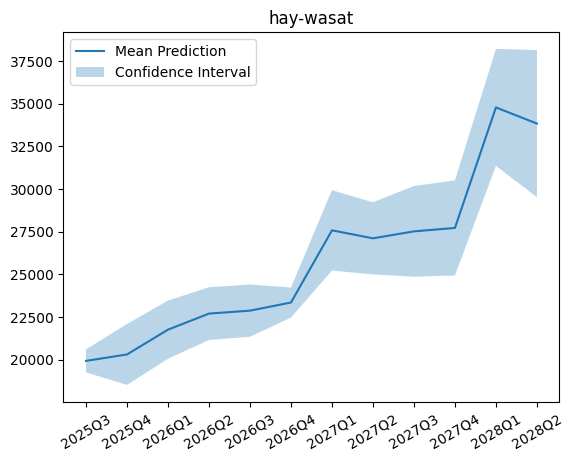

-----------------------------


In [16]:
# for i in range(4, 9):
#     run_model_for_area(i)

run_model_for_area(-5)

In [15]:
params

NameError: name 'params' is not defined

In [ ]:
(future_data_pca, future_data) = get_future_data(params)

alex = import_data(params["MOVING_AVG"])
alex = select_lags(alex, params["LAGS"])
(X_train, X_test, y_train, y_test) = data_preprocessing(alex, params["PCA"], params["Test-Size"])
(X_train, X_test, y_train, y_test, x_scaler, y_scaler) = scale_data(X_train, X_test, y_train, y_test)
# (r2, reg) = run_model(X_train, X_test, y_train, y_test, best_model_params)
# print(r2)
(lower_bound, upper_bound, means_preds) = get_ci(X_train, X_test, y_train, y_test, params, future_data_pca)

In [ ]:
means_preds = list(means_preds)
for i in range(len(means_preds)):
    print(q_labels[i] + " => (" + str(round(lower_bound[i], 2)) + ", " + str(round(upper_bound[i], 2)) + ") L.E.")

In [ ]:
forecast = pd.DataFrame()
forecast["Date"] = q_labels
forecast["Lower Bound"] = lower_bound
forecast["Upper Bound"] = upper_bound
forecast["Point Estimation"] = means_preds

forecast_df_path = alex.attrs['area'] + "-forecast" + ".csv"
forecast.to_csv(forecast_df_path)

import json
params_path = alex.attrs['area'] + "-params" + ".json"
with open(params_path, "w") as f:
    json.dump(params, f, indent=4)